<a href="https://colab.research.google.com/github/hectorcamachoz/Regresion_logistica_validacion_cruzada/blob/main/A2_1_594557.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresion logistica y validacion cruzada

En este ejercicio se utilizara la misma base de datos que en el proyecto 1. Inteligencia Artificial, que se puede encontrar en los repositorios de Github. La descripcion de cada una de las variables se encuentra en el archivo Descripcion_vars.txt

1. Se importara la base de datos y se limpiara. (Estos pasos ya se habian realizado en Proyecto 1. Inteligencia Artificial, si quieres conocer el porque de estos pasos, te invito a pasar al repositorio del proyecto). Lo que se medira es si se rentan mas de 2500 bicis al dia o no, ya que al ser verdadero se considera que fue un buen dia de rentas. Por lo tanto se agregara una variable que se llame 'renta_del_dia', esta variable sera 1, si se rentan mas de 2500 o 2500, y 0 si se rentan menos de 2500. Al hacer este cambio, se debe de eliminar la variable cnt.

In [40]:
import pandas as pd

df = pd.read_csv('day.csv')
df = df.drop('instant', axis=1)
df = df.drop('dteday', axis= 1)
df = df.drop('mnth', axis = 1)
df = df.drop('weekday', axis=1)
df = pd.get_dummies(df, columns=['season', 'weathersit'],drop_first=False, dtype = int)
df = df.drop('atemp', axis = 1)

df = df.drop('casual', axis = 1)
df = df.drop('registered', axis = 1)

renta_del_dia = []

for i in df['cnt']:
    if i >= 2500:
        renta_del_dia.append(1)
    else:
        renta_del_dia.append(0)
df = pd.concat([df, pd.Series(renta_del_dia, name='renta_del_dia')], axis=1)
df = df.drop('cnt', axis = 1)
df.head()

print(df.renta_del_dia.value_counts())


renta_del_dia
1    587
0    144
Name: count, dtype: int64


2. Se separaran los datos de forma que el 80% sera utilizado para el entrenamiento y el 20% para la validacion del modelo. Ademas, se le agregara un parametro a la funcion de train_test_split de sklearn, llamado stratify, esta se encarga de realizar una division de datos balanceada para mi variable de salida. Tambien realizare una seleccion de caracteristicas para eliminar cualquier variable que no tenga importancia con mi variable de salida.

In [41]:
x = df.drop('renta_del_dia', axis = 1)
y = df['renta_del_dia']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 42)

print("Distribución en y:\n", y.value_counts(normalize=True))
print("\nDistribución en y_train:\n", y_train.value_counts(normalize=True))
print("\nDistribución en y_test:\n", y_test.value_counts(normalize=True))

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression

md_seleccion = LogisticRegression()

sfs = SFS(md_seleccion, k_features= 'best',forward=True, floating = True, scoring='r2',cv=5)
sfs.fit(x_train, y_train)

selected_features = list(sfs.k_feature_names_)
print('\nCaracteristicas seleccionadas: ', selected_features)
print('R2 score: ', sfs.k_score_)

x_train = x_train[selected_features]
x_test = x_test[selected_features]



Distribución en y:
 renta_del_dia
1    0.80301
0    0.19699
Name: proportion, dtype: float64

Distribución en y_train:
 renta_del_dia
1    0.803082
0    0.196918
Name: proportion, dtype: float64

Distribución en y_test:
 renta_del_dia
1    0.802721
0    0.197279
Name: proportion, dtype: float64

Caracteristicas seleccionadas:  ['yr', 'holiday', 'temp', 'windspeed', 'season_4', 'weathersit_1', 'weathersit_2', 'weathersit_3']
R2 score:  0.6427163220037202


3. A continuacion, se utilizara la tecnica de StratifiedKFold de la libreria sklearn, en el cual se medira el accuracy de un modelo a partir de estos datos. Esta funcion la encontre utilizando ChatGpt.

In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
x_np = x_train.to_numpy()
y_np = y_train.to_numpy()
i = 1
# Este es un split, dentro del split
for train_index, test_index in skf.split(x_np, y_np):
    X_train_2, X_test_2 = x_train.iloc[train_index], x_train.iloc[test_index]
    y_train_2, y_test_2 = y_train.iloc[train_index], y_train.iloc[test_index]

    model = LogisticRegression()
    model.fit(X_train_2, y_train_2)

    y_pred = model.predict(X_test_2)
    accuracy = accuracy_score(y_test_2, y_pred)
    print(f"Fold",[i]," Accuracy:", round(accuracy,3))
    i+=1

Fold [1]  Accuracy: 0.932
Fold [2]  Accuracy: 0.949
Fold [3]  Accuracy: 0.923
Fold [4]  Accuracy: 0.94
Fold [5]  Accuracy: 0.94


4. Se realizara un modelo con todos los datos de entrenamiento, utilizando una regresion logistica multivariable, se generara un vector de probabilidades para los datos de prueba, y a su vez se generara una matriz de confusion junto con la exactitud, sesibilidad y especificidad del modelo ante 3 umbrales distintos.


In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score
model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:,1]
print('Vector de probabilidades: \n', y_pred_proba)

umbrales = [0.3, 0.5, 0.7]

for umbral in umbrales:
    print(f"\nEvaluación para umbral = {umbral}")

    y_pred = (y_pred_proba >= umbral).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    exactitud = accuracy_score(y_test, y_pred)
    sensibilidad = tp / (tp + fn) if (tp + fn) > 0 else 0
    especificidad = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Imprimir resultados
    print(f"Matriz de confusión:\n{confusion_matrix(y_test, y_pred)}")
    print(f"Exactitud: {exactitud:.4f}")
    print(f"Sensibilidad: {sensibilidad:.4f}")
    print(f"Especificidad: {especificidad:.4f}")

Vector de probabilidades: 
 [0.97307128 0.78332976 0.87281921 0.87207874 0.90952057 0.99108153
 0.51967726 0.99420998 0.99432558 0.95377888 0.24469244 0.92243512
 0.94207494 0.95546545 0.85890633 0.99567519 0.12204888 0.96496454
 0.84859031 0.98920007 0.96855367 0.97489266 0.93881245 0.9786864
 0.81019122 0.95834788 0.98439435 0.94821352 0.93941236 0.96820052
 0.99604152 0.97275367 0.54609326 0.99401908 0.88404274 0.40900548
 0.993266   0.86401455 0.98524079 0.91557834 0.89963857 0.64069633
 0.47899903 0.9395254  0.42321858 0.95466186 0.68255838 0.98857359
 0.97344132 0.9885826  0.32917474 0.9540649  0.95910886 0.66481097
 0.98727842 0.95361217 0.66438845 0.40849829 0.96991874 0.96501171
 0.76141285 0.94098946 0.89905402 0.99515541 0.41159186 0.97021408
 0.74679549 0.9424684  0.97963436 0.98944399 0.97737438 0.97039355
 0.90323072 0.98204895 0.98327514 0.57764375 0.97292659 0.98991174
 0.99095536 0.47780378 0.99556751 0.99284087 0.49891362 0.99461441
 0.98045181 0.96399162 0.63647319 0

Al observar los resultados de las matrices de confusion y los parametros de exactitud, sensibilidad y especificidad de cada valor del umbral, se puede concluir que para el umbral de valor de 0.3, todos los casos true positive fueron correctamente predichos, y presento una especificidad del 17% con una exactitud del 86%. Para el umbral de valor 0.5, la sensibilidad tuvo un valor de 1, la proporcion de casos negativos correctamente predichos fue de 58% y conto con una exactitud de 91%. Por ultimo, para el umbral de valor de 0.7, la sensibilidad fue del  98 % la especificidad del 89% y la proporcion de predicciones que fueron correctas fue del 96%. Se podrian utilizar cualquiera de los tres valores del umbral, todo depende de la aplicacion del modelo, si se especifica que siempre queremos que el modelo este 100% seguro de que se rentaron mas de 2500, podriamos utilizar el umbral 0.3 o 0.5. Sin embargo, como la aplicacion de este modelo no especifica, en lo personal me iria por el umbral de 0.7 ya que es el mas balanceado, en las tres medidas.

5. Se generara una curva ROC para las probabilidades calculadas, y se calculara el valor del AUC.

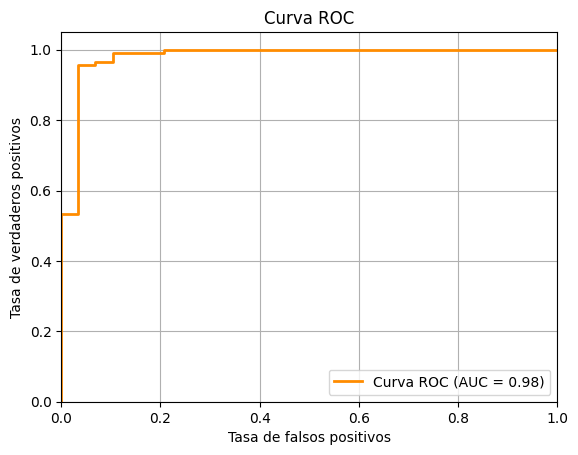

AUC: 0.9804208065458796


,Variable,Coeficiente,Odds Ratio
0,yr,1.852321,6.374597
1,holiday,-0.989798,0.371652
2,temp,7.201434,1341.353394
3,windspeed,-0.878603,0.415363
4,season_4,1.766406,5.849794
5,weathersit_1,1.019558,2.771970
6,weathersit_2,0.478355,1.613418
7,weathersit_3,-1.530721,0.216380


In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)


roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC: {roc_auc}")


coef_df = pd.DataFrame({'Variable': x_train.columns, 'Coeficiente': model.coef_[0], 'Odds Ratio': odds_ratios[0]})
coef_df

Al observar el AUC de 0.98 se puede concluir que el modelo puede clasificar correctamente la mayoria de los datos. Debajo del valor de AUC, se observan los coeficientes y los Odds Ratios de cada una de las variables, se puede concluir que existen 5 variables que si presentaran un aumento, estas ocasionan un aumento en las probabilidades de que la salida sea 1, en este caso que se renten mas de 2500 bicicletas, esas variables son: yr, temp, season_4,  weathersit_1 , weathersit_2. Las variables que aumentando disminuyen las probabilidades de que la salida sea 1 son: holiday, windspeed, weathersit_3.